# Single-Shot CNN Denoising

We demonstrate that a deep neural net can be trained to denoise a _single_ noisy image, taking advantage of the fact that one 512 x 512 image contains ~250,000 dimensions of information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters import gaussian, median
from skimage import data, img_as_float, img_as_ubyte
from skimage.color import gray2rgb
from skimage.util import random_noise
from skimage.measure import compare_psnr

In [5]:
plt.rc('figure', figsize = (5,5))

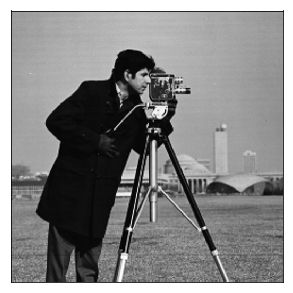

In [6]:
image = data.camera()
show(image)

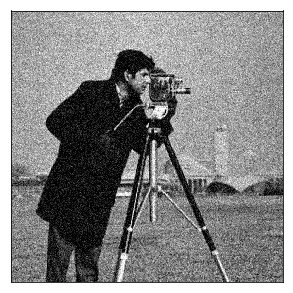

In [15]:
np.random.seed(3)
noisy_image = random_noise(image, mode = 'gaussian', var=0.01)
show(noisy_image)

In [8]:
import torch
noisy = torch.Tensor(noisy_image[np.newaxis, np.newaxis])/256

In [9]:
from util import getbestgpu
device = getbestgpu()

GPU device 0 has 12179 MiB left.
GPU device 1 has 1112 MiB left.
GPU device 2 has 7452 MiB left.
GPU device 3 has 7452 MiB left.
--> GPU device 0 was chosen


# Masking

The strategy is to train a $J$-invariant version of a neural net by replacing a grid of pixels with the average of their neighbors, then only evaluating the model on the masked pixels.

In [16]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [43]:
torch.manual_seed(3)
from models.babyunet import BabyUnet
from models.unet import Unet
from models.dncnn import DnCNN

model = DnCNN(1)

In [47]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

556032

In [49]:
image.ravel().shape

(262144,)

# Training

In [44]:
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [45]:
model = model.to(device)
noisy = noisy.to(device)

In [46]:
losses = []
val_losses = []
best_images = []
best_val_loss = loss_function(noisy, 0*noisy)

for i in range(500):
    model.train()
    
    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()
    
    if i % 10 == 0:
        print("Loss (", i, "): \t", round(loss.item(), 4))
        losses.append(loss.item())
        model.eval()
        
        net_input, mask = masker.mask(noisy, masker.n_masks - 1)
        net_output = model(net_input)
    
        val_loss = loss_function(net_output*mask, noisy*mask)
        
        print("Val Loss (", i, "): \t", round(val_loss.item(), 5))
        val_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_images.append(model(noisy).detach().cpu())
            best_psnr = compare_psnr(np.clip(best_images[-1][0,0].numpy(), 0, 1), img_as_float(image))
            print("Best PSNR: ", np.round(best_psnr, 2))

Loss ( 0 ): 	 0.0191
Val Loss ( 0 ): 	 0.01743
Best PSNR:  5.66
Loss ( 10 ): 	 0.0017
Val Loss ( 10 ): 	 0.00931
Best PSNR:  8.45
Loss ( 20 ): 	 0.0007
Val Loss ( 20 ): 	 0.00405
Best PSNR:  12.33
Loss ( 30 ): 	 0.0007
Val Loss ( 30 ): 	 0.00168
Best PSNR:  17.19
Loss ( 40 ): 	 0.0007
Val Loss ( 40 ): 	 0.00112
Best PSNR:  20.12
Loss ( 50 ): 	 0.0006
Val Loss ( 50 ): 	 0.00079
Best PSNR:  23.93
Loss ( 60 ): 	 0.0007
Val Loss ( 60 ): 	 0.00073
Best PSNR:  25.22
Loss ( 70 ): 	 0.0006
Val Loss ( 70 ): 	 0.0007
Best PSNR:  26.39
Loss ( 80 ): 	 0.0006
Val Loss ( 80 ): 	 0.00066
Best PSNR:  27.81
Loss ( 90 ): 	 0.0006
Val Loss ( 90 ): 	 0.00064
Best PSNR:  28.49
Loss ( 100 ): 	 0.0006
Val Loss ( 100 ): 	 0.00063
Best PSNR:  29.03
Loss ( 110 ): 	 0.0006
Val Loss ( 110 ): 	 0.00063
Best PSNR:  29.34
Loss ( 120 ): 	 0.0006
Val Loss ( 120 ): 	 0.00062
Best PSNR:  29.96
Loss ( 130 ): 	 0.0006
Val Loss ( 130 ): 	 0.00062
Best PSNR:  30.25
Loss ( 140 ): 	 0.0006
Val Loss ( 140 ): 	 0.00062
Best PSN

In [54]:
denoised = np.clip(best_images[-1][0,0].numpy(), 0, 1)

In [55]:
compare_psnr(denoised, img_as_float(image))

31.251697277352495

In [52]:
inset_x_min = 100
inset_x_max = 160
inset_y_min = 230
inset_y_max = 290

get_inset = lambda x: x[inset_x_min:inset_x_max, inset_y_min:inset_y_max]

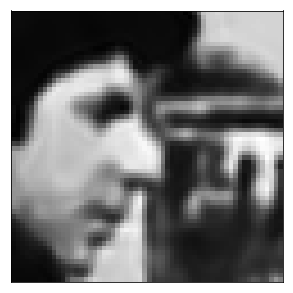

In [56]:
show(get_inset(denoised))